**Condorcet ranking**

In [103]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/wmt15engfre.csv', sep=',')

# Create a list of dictionaries to store the Condorcet ranks for each segmentId
results = []

# Loop through each segmentId
for segmentId in df.segmentId.unique():
    # Create a dictionary to store the Copeland scores for each system
    system_scores = {}
    # Loop through each row with the current segmentId
    for _, row in df[df.segmentId == segmentId].iterrows():
        # Get the system IDs and ranks
        system1 = row['system1Id']
        system2 = row['system2Id']
        rank1 = row['system1rank']
        rank2 = row['system2rank']
        # Update the scores for the first system
        if system1 not in system_scores:
            system_scores[system1] = 0
        if rank1 < rank2:
            system_scores[system1] += 1
        # Update the scores for the second system
        if system2 not in system_scores:
            system_scores[system2] = 0
        if rank2 < rank1:
            system_scores[system2] += 1
    # Calculate the Copeland score for each system
    copeland_scores = {}
    for system in system_scores:
        copeland_scores[system] = sum([1 for other_system in system_scores if system_scores[other_system] < system_scores[system]])
    # Calculate the Condorcet rank for each system
    condorcet_ranks = {}
    for system in copeland_scores:
        rank = 1
        for other_system in copeland_scores:
            if copeland_scores[other_system] > copeland_scores[system]:
                rank += 1
        condorcet_ranks[system] = rank
    # Add the Condorcet ranks for this segmentId to the results list
    results.append(condorcet_ranks)

# Create a new DataFrame with the Condorcet ranks
result_df = pd.DataFrame(results)
result_df.to_csv('pivoted_wmt15engfre.csv', index=False)

**Averaging across judges**

In [99]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/wmt15engfre.csv')

# Duplicate rows with swapped system ids and ranks
df_swapped = df.rename(columns={'system1Id': 'system2Id', 'system1rank': 'system2rank', 'system2Id': 'system1Id', 'system2rank': 'system1rank'})
df_augmented = pd.concat([df, df_swapped], ignore_index=True)

# Pivot the data to create a new DataFrame with one column per unique value of "system1Id" and "system2Id"
seg_IDs = df_augmented['segmentId'].unique()
df_augmented['segmentId'] = pd.Categorical(df_augmented['segmentId'], categories=seg_IDs, ordered=True)
df_sorted = df_augmented.sort_values(by='segmentId')

pivoted_system1 = df_augmented.pivot_table(index=['segmentId', 'judgeID'], columns='system1Id', values='system1rank', aggfunc='mean')
pivoted_system2 = df_augmented.pivot_table(index=['segmentId', 'judgeID'], columns='system2Id', values='system2rank', aggfunc='mean')

# Merge the two pivot tables
pivoted = pd.concat([pivoted_system1, pivoted_system2], axis=1)

# Rename the columns to indicate that they contain system ranks
pivoted.columns = [f'{col}_rank' for col in pivoted.columns]

# Save the pivoted data to a new CSV file

pivoted.groupby('segmentId').mean().iloc[:,0:7].to_csv('/content/pivoted_wmt15engfre.csv')

**Ranking according to the different metrics**

In [104]:
import csv
import re

models = ['BERT_scores', 'BLEU_scores', 'bary_scores', 'depth_scores', 'mover_scores']
for i in range(len(models)):
  # Read the input CSV file
  with open('/content/' + models[i] + '.csv', 'r') as f:
      reader = csv.reader(f)
      rows = [row for row in reader]
      rows = rows[1:]

  # Compute the ranks of each value in each row
  for row in rows:
      # Extract the numeric values
      if models[i] == 'BERT_scores':
        values = [float(re.search(r'[-+]?\d*\.\d+|\d+', val).group()) for val in row[1:]]
      else:
        values = [float(val) for val in row[1:]]
      # Sort the values in descending order
      sorted_values = sorted(values, reverse=True)
      # Compute the ranks of each value
      ranks = [sorted_values.index(val) + 1 for val in values]
      # Replace the values with their ranks
      for j in range(len(values)):
          row[j+1] = str(ranks[j])

  # Write the modified list of lists to a new CSV file
  with open('/content/' + models[i] + '_ranks.csv', 'w', newline='') as f:
      writer = csv.writer(f)
      writer.writerows(rows)

**Correlation scores: Pearson, Spearman and Kendall**

/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Spearman for BERT_scores:0.03828327956906386
Spearman for BLEU_scores:0.08055234638196113
Spearman for bary_scores:0.013821312503857862
Spearman for depth_scores:0.012209648165413423
Spearman for mover_scores:0.029728901845974234


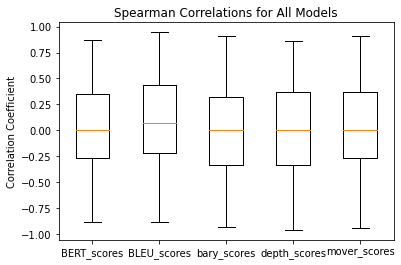

In [105]:
import csv
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
import math
import matplotlib.pyplot as plt

def correlations(model):
  # Read in the two CSV files
  condorcet_ranks = []
  with open('/content/pivoted_wmt15engfre.csv', 'r') as f:
      reader = csv.reader(f)
      for i, row in enumerate(reader):
        if i > 0:
          condorcet_ranks.append([int(float(x)) if x != '' else None for x in row])

  bleu_scores_ranks = []
  with open('/content/' + model + '_ranks.csv', 'r') as f:
      reader = csv.reader(f)
      for row in reader:
        if model=='BERT_scores':
          bleu_scores_ranks.append([int(float(re.search(r'[-+]?\d*\.\d+|\d+', x).group())) for x in row])
        else:
          bleu_scores_ranks.append([int(float(x)) for x in row])

  # Fill in missing values in condorcet_ranks with the average rank
  for i in range(len(condorcet_ranks)):
      num_filled = sum([1 for x in condorcet_ranks[i] if x is not None])
      if num_filled > 0:
          avg_rank = sum([x for x in condorcet_ranks[i] if x is not None]) / num_filled
          for j in range(len(condorcet_ranks[i])):
              if condorcet_ranks[i][j] is None:
                  condorcet_ranks[i][j] = avg_rank

  # Compute the correlation scores row by row
  pearson_scores = []
  spearman_scores = []
  kendall_scores = []

  for i in range(len(condorcet_ranks)):
      spearman, _ = spearmanr(condorcet_ranks[i], bleu_scores_ranks[i][1:])
      if not math.isnan(spearman):
        spearman_scores.append(spearman)

  # Print out the correlation scores
  return np.mean(spearman_scores), spearman_scores

fig, ax = plt.subplots()
scores_array = []
for model in models:
  mean, spearman_scores = correlations(model)
  print('Spearman for ' + model + ':' + str(mean))
  scores_array.append(spearman_scores)
# create boxplot
ax.boxplot(scores_array)
ax.set_xticklabels(models)
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Spearman Correlations for All Models')
plt.show()